#Crop price forcasting

You are in a data science team of a food company. A key information for your company is the price of crops because they are directly related to the cost of your products. You are given weekly crop price data from 2013 to 2017. Your task is to learn about the data and finally try to create some model that can predict crop prices. This prediction model will be used to set a price range for buying crops for the upcoming year.

In [ ]:
# get data
! wget https://raw.githubusercontent.com/Pataweepr/scb_TS_course/master/exam/time-series/cropprice2013-2017.csv

--2022-07-09 12:56:03--  https://raw.githubusercontent.com/Pataweepr/scb_TS_course/master/exam/time-series/cropprice2013-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4314 (4.2K) [text/plain]
Saving to: ‘cropprice2013-2017.csv.3’

cropprice2013-2017. 100%[===================>]   4.21K  --.-KB/s    in 0s      

2022-07-09 12:56:03 (17.7 MB/s) - ‘cropprice2013-2017.csv.3’ saved [4314/4314]



In [ ]:
!pip install statsmodels -U # colab uses an old version of statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



0. Visualize the data. Fill any missing values using methods you deem appropriate.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/cropprice2013-2017.csv',header=None,names=['date','value'])#,index_col='date')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df['dayofweek'] = df['date'].dt.day_name()


In [ ]:
df

,date,value,dayofweek
27,2013-01-09,9.09130,Wednesday
40,2013-01-12,8.16952,Saturday
14,2013-02-06,10.10080,Wednesday
0,2013-02-24,10.15942,Sunday
1,2013-03-03,10.25856,Sunday
...,...,...,...
228,2017-08-27,5.87450,Sunday
211,2017-09-04,6.18920,Monday
221,2017-09-07,6.30340,Thursday
203,2017-12-02,6.33186,Saturday


In [ ]:
df['dayofweek'].describe()

count        230
unique         7
top       Sunday
freq         151
Name: dayofweek, dtype: object

In [ ]:
# from information about days of week, assume that the data is the crops price on every sunday.

idx = pd.date_range('2013-01-09','2017-12-03')

df.index = pd.DatetimeIndex(df['date'])
df = df.reindex(idx)
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(by='date')
df['dayofweek'] = df.index.day_name()
df = df.drop(columns='date')


In [ ]:
df['interp_value'] = df['value'].interpolate()
sunday_df = df[df['dayofweek'] == 'Sunday']

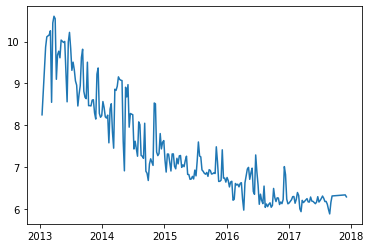

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sunday_df.index,sunday_df['interp_value'],)

In [ ]:
import statsmodels as ss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np

date = sunday_df.index
price = sunday_df['interp_value']

1. What kind of time series is this data (additive, multiplicative, univariate, multivariate) ? Justify your answer.

Considering the data, we are dealing with univiraite and multiplicative time series, where the crop price is the only one variable and the variance of the data seems to change over time in according to the mean price. Although looking at the difference between additive decompose and multiplicative decompose, there seem to be no real difference. So both answers can be considered okay for modeling.
Regarding the period, our gut feeling says that the period should be 52 (week). The result on the decompose seems to make sense so this should be correct.

In [ ]:
decompos_add = seasonal_decompose(price,model='additive',period=52)
trend_add = decompos_add.trend
seasonal_add = decompos_add.seasonal
residual_add = decompos_add.resid

In [ ]:
decompos_multi = seasonal_decompose(price,model='multiplicative',period=52)
trend_multi = decompos_multi.trend
seasonal_multi = decompos_multi.seasonal
residual_multi = decompos_multi.resid

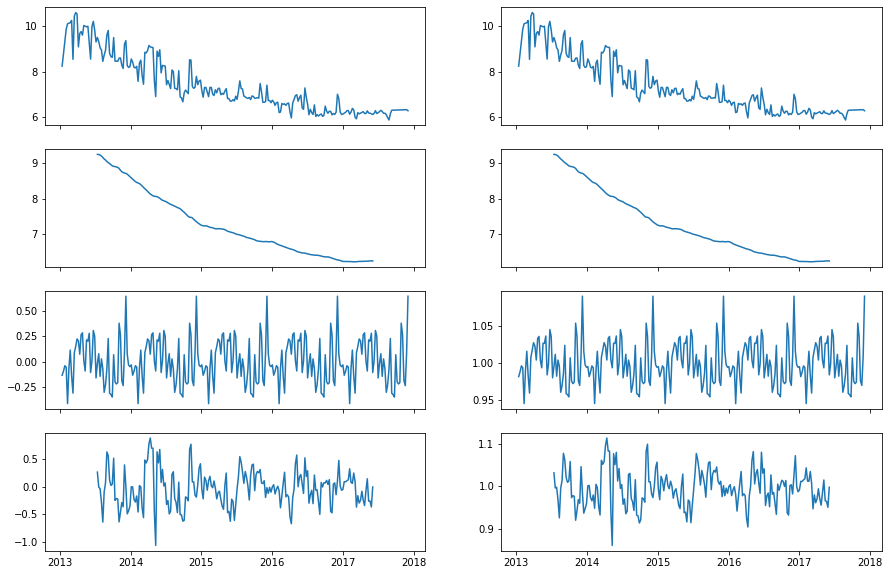

In [ ]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0,0].plot(price, label='Observed')
axes[1,0].plot(trend_add, label='Trend')
axes[2,0].plot(seasonal_add, label='Seasonality')
axes[3,0].plot(residual_add, label='Residuals')

axes[0,1].plot(price, label='Observed')
axes[1,1].plot(trend_multi, label='Trend')
axes[2,1].plot(seasonal_multi, label='Seasonality')
axes[3,1].plot(residual_multi, label='Residuals')

2. Is there any seasonality in the data? What should be the period? Justify your answer.

Yes, the period should be a year. See previous answer.

3. Is this data stationary? Justify your answer. If not, perform transformations to convert this data to be more stationary.

No, it is not because data shows strong trend and seasonality.

Using difference and log scaling seems to make the time series more stationary.

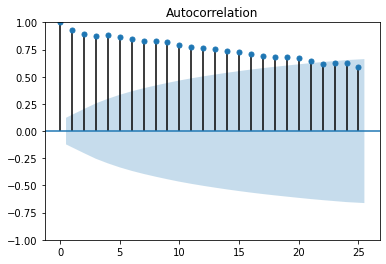

In [ ]:
plot_acf(price);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


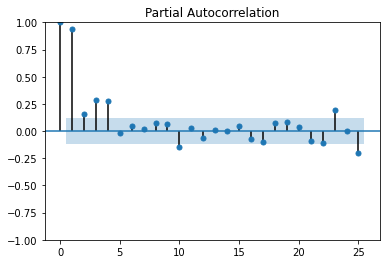

In [ ]:
plot_pacf(price);

In [ ]:
diffLogPrice = np.log(price) - np.log(price.shift())

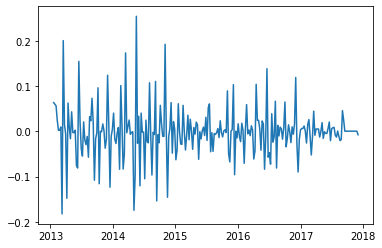

In [ ]:
plt.plot(diffLogPrice)

In [ ]:
result = adfuller(diffLogPrice.dropna(), autolag='AIC')
result = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(result)

Test Statistic                -8.572375e+00
p-value                        8.132190e-14
#Lags Used                     7.000000e+00
Number of Observations Used    2.470000e+02
dtype: float64


4. Create a model to predict the price in year 2017. You will be graded mostly on the methodology rather than the final prediction accuracy. Be sure to discuss about your choice of metrics, the data you used to train/validate your model, how your pick the type of model, and how you pick the hyperparameters.

Since we're dealing with commodities which seem to fluctuate in price over the years, it seems calculating percentage error should be better than straight MSE. Thus, we are using the MAPE.

Then we will perform hyperparameter tuning using a validation set. Using the 2016 as validation and 2014-2015 as training.

In [ ]:
import statsmodels

statsmodels.__version__

'0.13.2'

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def mape(y_true,y_pred):
  return abs((y_true - y_pred) / y_true).sum() / len(y_true)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

best_avg_mape = np.inf

# using SARIMAX becasuse of the data has seansonality
# select range of p and q from ACF and PACF
# ignore the P,D,Q of seasonality order

for p in [0,3,6,10]:
  for d in [1]:
    for q in [0,4,5]:
      try:
        sum_pred_mape = 0
        for start_end in [('2013','2015','2016')]:
          sarima_model = sm.tsa.statespace.SARIMAX(price.loc[start_end[0]:start_end[1]],order=(p,d,q),seasonal_order=(0,0,0,52)).fit()
          sum_pred_mape += mape(price.loc[start_end[2]].to_numpy(),sarima_model.forecast(step = 52).to_numpy())
        if sum_pred_mape/2 < best_avg_mape:
          print(sum_pred_mape/2,p,d,q,52)
          best_avg_mape = sum_pred_mape/2
      except:
        print(p,d,q,'failed')

0.024984924018269038 0 1 0 52


In [ ]:
# Now let's tune P,Q
# Note that we should tune P,D,Q and p,d,q together but this is to save time

best_avg_mape = np.inf

for P in [0,3]:
  for D in [0,1]:
    for Q in [0,3]:
      try:
        sum_pred_mape = 0
        for start_end in [('2013','2015','2016')]:
          sarima_model = sm.tsa.statespace.SARIMAX(price.loc[start_end[0]:start_end[1]],order=(0,1,0),seasonal_order=(P,D,Q,52)).fit()
          sum_pred_mape += mape(price.loc[start_end[2]].to_numpy(),sarima_model.forecast(step = 52).to_numpy())
        if sum_pred_mape/2 < best_avg_mape:
          print(sum_pred_mape/2,P,D,Q,52)
          best_avg_mape = sum_pred_mape/2
      except:
        print(P,D,Q,'failed')

0.024984924018269038 0 0 0 52
0.023409265434197465 0 0 3 52
0.023280023086604342 0 1 0 52


In [ ]:
sarima_model = sm.tsa.statespace.SARIMAX(price.loc['2013':'2016'],order=(0,1,0),seasonal_order=(0,1,0,52)).fit()

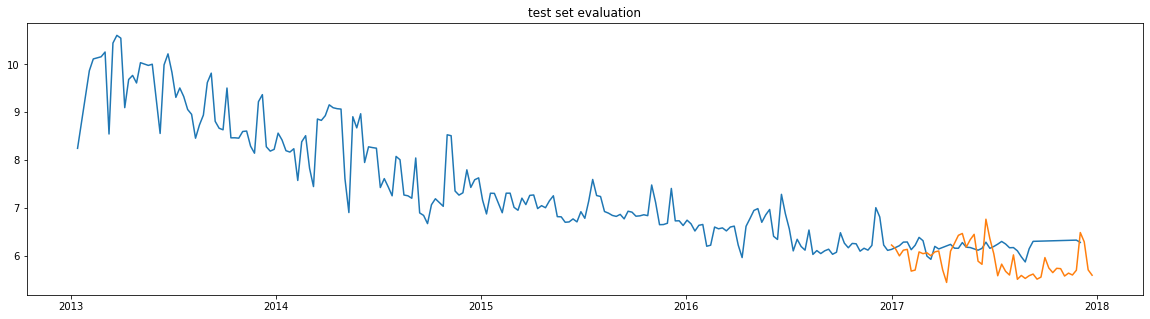

In [ ]:
plt.figure(figsize = (20, 5))
plt.title('test set evaluation')
plt.plot(price, label = 'GT')
plt.plot(sarima_model.forecast(52), label = 'pred')
# plt.fill_between(confidence_int.index,confidence_int['lower 1'],confidence_int['upper 1'],alpha = 0.05)
# plt.legend()
# plt.grid()

5. Consider the prediction results from your "best" model in problem 3. What should you be cautious about when you deploy this model in the company? If given another week, what might you do to improve this model?

Even though the best fit model seems to perform well on validation data, it does not work well on the evaluation set. The model seems to try to capture the downward trend of the price which makes the 2017 prediction to be off since the price in 2017 does not follow that trend. This is the downside of pure time series modeling it assumes that previous data predicts the future.

There might be some possible lowerbound of the price that cannot go below. It might be possible to try Prophet and add more domain knowledge about possible lowerbounds in price in the future.